In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from tqdm import tqdm
import cv2
import os
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle as sk_shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds

In [7]:
from src.data import get_data
from src.data import get_image_value

In [44]:
dim = (224,224)
model_type = 'Mobilenet'
bw = False

train_paths, train_labels = get_data('training')
train_images = np.array([get_image_value(i, dim, bw, model_type) for i in train_paths])
train_dict = dict(images = train_images, labels = train_labels)

TRAINING Value Counts
1    5101
0    4899
dtype: int64


In [67]:
valid_paths, valid_labels = get_data('validation')
valid_images = np.array([get_image_value(i, dim, bw, model_type) for i in valid_paths])
valid_dict = dict(images = valid_images, labels = valid_labels)

VALIDATION Value Counts
1    508
0    492
dtype: int64


In [69]:
test_paths, test_labels = get_data('test')
test_images = np.array([get_image_value(i, dim, bw, model_type) for i in test_paths])
test_dict = dict(images = test_images, labels = test_labels)

TEST Value Counts
0    26
1    19
dtype: int64


In [19]:
data_dir = './data/images/syn/'
img_height = 224
img_width = 224
batch_size = 16

In [20]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  f"{data_dir}/training",
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

<IPython.core.display.Javascript object>

Found 10000 files belonging to 2 classes.


In [21]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
  f"{data_dir}/validation",
  #validation_split=0.2,
  #subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

<IPython.core.display.Javascript object>

Found 1000 files belonging to 2 classes.


In [42]:
train_images.shape

(196, 224, 224, 3)

In [70]:
x_train = train_images
y_train = train_labels
x_valid = valid_images
y_valid = valid_labels
x_test = test_images
y_test = test_labels

In [71]:
from src.model import MobileNet

# Classification Task 

In [72]:
model = MobileNet(input_shape = (224,224,3))

(224, 224, 3)


mobilenet_history = model.model.fit(train_ds,
                                              epochs = 50, #model.epochs, 
                                              callbacks = [#model.early_stopping, 
                                                           model.model_checkpoint, 
                                                           model.lr_plat,
                                                           model.tensorboard_history],
                                              validation_data = valid_ds,
                                              verbose= 1)
                                              

In [73]:
augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)

In [74]:
augmentation.fit(x_train)

In [75]:
mobilenet_history = model.model.fit_generator(augmentation.flow(x_train, y_train, batch_size = model.batch_size),
                                              epochs = 10, #model.epochs, 
                                              callbacks = [#model.early_stopping, 
                                                           model.model_checkpoint, 
                                                           model.lr_plat,
                                                           model.tensorboard_history],
                                              validation_data = (x_valid, y_valid),
                                              verbose= 1)
                                              

Epoch 1/10
157/157 [==============================] - 112s 696ms/step - loss: 0.3364 - accuracy: 0.8397 - val_loss: 0.0124 - val_accuracy: 0.9970

Epoch 00001: val_loss improved from inf to 0.01238, saving model to ./data/models/mobilnet/mobilenet.h5
Epoch 2/10
157/157 [==============================] - 106s 676ms/step - loss: 0.0285 - accuracy: 0.9946 - val_loss: 0.0051 - val_accuracy: 0.9990

Epoch 00002: val_loss improved from 0.01238 to 0.00511, saving model to ./data/models/mobilnet/mobilenet.h5
Epoch 3/10
157/157 [==============================] - 106s 674ms/step - loss: 0.0142 - accuracy: 0.9969 - val_loss: 0.0032 - val_accuracy: 0.9980

Epoch 00003: val_loss improved from 0.00511 to 0.00317, saving model to ./data/models/mobilnet/mobilenet.h5
Epoch 4/10
157/157 [==============================] - 106s 672ms/step - loss: 0.0129 - accuracy: 0.9966 - val_loss: 0.0027 - val_accuracy: 0.9990

Epoch 00004: val_loss improved from 0.00317 to 0.00271, saving model to ./data/models/mobiln

In [ ]:
# val_accuracy: 0.7857

In [77]:
pred = model.model.predict(x_test)

In [76]:
model = tf.keras.models.load_model(f"./data/models/mobilnet/mobilenet.h5")

<IPython.core.display.Javascript object>

In [77]:
pred = model.predict(x_test)

In [78]:
pred[:10]

array([[0.9818703 ],
       [0.9999862 ],
       [0.00374631],
       [0.99930596],
       [0.09506416],
       [0.99981683],
       [0.99999475],
       [0.81487036],
       [0.9616279 ],
       [0.9951367 ]], dtype=float32)

In [95]:
df_output = pd.DataFrame()
df_output['pred']=np.reshape(pred, (len(pred), ))
df_output['pred'] = (df_output['pred']>0.5).astype(int)
df_output['y_true']=y_test

In [96]:
df_output

,pred,y_true
0,1,1
1,1,1
2,0,1
3,1,1
4,0,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


In [80]:
x_test.shape

(45, 224, 224, 3)

In [83]:
y_test[:30]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [84]:
pred[30]

array([2.978861e-06], dtype=float32)

In [66]:
y_test.mean()

0.508

In [39]:
image_batch, label_batch = next(iter(train_ds))

In [40]:
label_batch

<tf.Tensor: shape=(16,), dtype=int32, numpy=array([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1], dtype=int32)>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


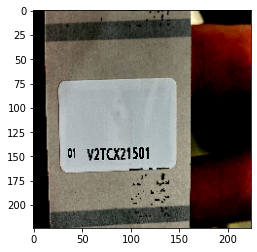

In [85]:
plt.imshow(x_test[30])

In [87]:
pred[-4]

array([0.00362585], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


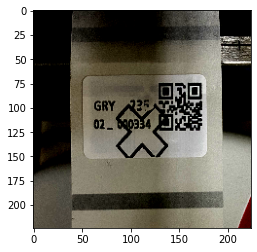

In [86]:
plt.imshow(x_test[-4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


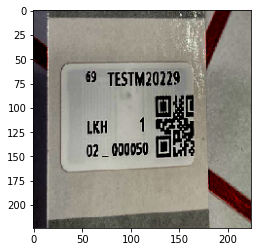

In [80]:
plt.imshow(x_test[-6])

In [70]:
valid_path = [os.path.join('./data/images/valid', i) for i in os.listdir('./data/images/valid/')]
valid_images = np.array([get_image_value(i, dim, bw, model_type) for i in valid_path])

In [71]:
pred = model.model.predict(valid_images)

In [84]:
pred = model.predict(valid_images)

In [85]:
pred

array([[0.10280299],
       [0.09348556],
       [0.04939765],
       [0.23208591]], dtype=float32)

In [72]:
pred

array([[0.06080627],
       [0.08988719],
       [0.03558422],
       [0.07433975]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


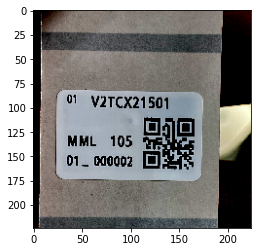

In [17]:
plt.imshow(x_test[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


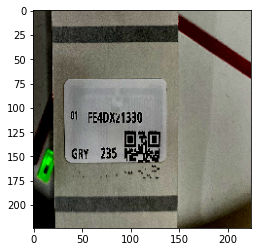

In [41]:
plt.imshow(x_test[10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


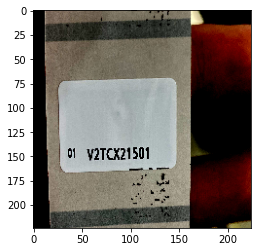

In [47]:
plt.imshow(x_test[9])

# Bounding Box Regression

In [104]:
from src.model import make_bbox


In [105]:
from src.data import get_bbox_image

In [112]:
from tensorflow.keras.optimizers import Adam

In [132]:

img, label = get_bbox_image('./data/images/box', 'train')

In [133]:
train_box_images = np.array([get_image_value(i, dim, bw, 'Mobilenet') for i in img])

In [134]:
x_train_box = train_box_images
y_train_box = label

In [147]:
bbox_model = make_bbox((224, 224, 3))

In [153]:
bbox_model.compile(loss="mse", optimizer='Adam')

In [154]:
bbox_model.fit(x_train_box, y_train_box,
               epochs=10,
               batch_size=32,
               verbose=0)

In [155]:
bbox_model.fit(x_train_box, y_train_box,
               epochs=5,
               batch_size=32,
               verbose=1)

Epoch 1/5
1/1 [==============================] - 0s 77ms/step - loss: 0.1586
Epoch 2/5
1/1 [==============================] - 0s 72ms/step - loss: 0.1799
Epoch 3/5
1/1 [==============================] - 0s 72ms/step - loss: 0.1811
Epoch 4/5
1/1 [==============================] - 0s 71ms/step - loss: 0.1876
Epoch 5/5
1/1 [==============================] - 0s 70ms/step - loss: 0.1929


In [156]:
pred = bbox_model.predict(x_train_box)

In [157]:
pred

array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 9.9720842e-01, 1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 4.2137430e-36, 1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.0200378e-31],
       [0.0000000e+00, 9.3057601e-21, 1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.2163362e-05, 1.0000000e+00, 2.1501589e-10],
       [0.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+